# BQA as bcolz arrays

Author: duckworthd@

This notebook converts a pickled DataFrame of per-site, per-date images to the format Sina used for storing satellite images.

In [3]:
# Set root directory to nearest parent folder for this file
import os
import cPickle as pickle
import sys

def git_root(current_dir=None):
    """Find root directory for a github repo above 'current_dir'.
    
    Args:
        current_dir: str. Path to directory within a git repo. 
            If None, defaults to the current working directory.
            
    Returns:
        Path to parent directory containing '.git'.
        
    Raises:
        ValueError: If no parent directory contains '.git'.
    """
    result = current_dir or os.getcwd()
    while True:
        if '.git' in os.listdir(result):
            return result
        if result == "/":
            raise ValueError("Could not find parent directory containing .git.")
        result = os.path.dirname(result)

def maybe_add_to_sys_path(path):
    """Add 'path' to 'sys.path' if it's not already there."""
    if path in sys.path:
        return
    sys.path.append(path)
    
maybe_add_to_sys_path(git_root())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from duckworthd import mining

%matplotlib inline

In [29]:
# Root directory containing mining site masks.

BQA_DATAFRAME_PATH = "/home/daniel/Desktop/datakind/data/bqa_masks_pickle/bqa_mask_all_conf_levels.pickle"
BQA_IMAGES_OUTPUT_DIR = "/home/daniel/Desktop/datakind/data/bqa_masks"

In [20]:
# Load BQA masks. Drop all rows that don't relate to masks.

with open(BQA_DATAFRAME_PATH) as f:
    bqa_masks_df = pickle.load(f).reset_index()

print '#sites:', len(bqa_masks_df["site_idx"].unique())
print '#sites * # dates:', len(bqa_masks_df[["site_idx", "date"]].drop_duplicates())
print 'mask shape:', bqa_masks_df.iloc[0]["cloud_mask_conf"].shape

#sites: 230
#sites * # dates: 11500
mask shape: (100, 100)


In [24]:
# Convert into per-site numpy arrays.
#
# TODO(duckworthd): Verify that "site_idx" == "vid".

imgs = []
metadata = []
for vid, group in bqa_masks_df.groupby("site_idx"):
    group = group.sort_values("date")
    img = np.stack(list(group["cloud_mask_conf"]), axis=-1)
    img = np.reshape(img, (img.shape[0], img.shape[1], 1, img.shape[2]))
    img_metadata = pd.Series({
        "bands": ['bqa'],
        "collection": 'bqa',
        "dates": list(group["date"]),
        "dim": list(img.shape),
        "fpath": "%d/%s" % (vid, 'bqa'),
        "id": vid,
    })
    
    imgs.append(img)
    metadata.append(img_metadata)
metadata = pd.DataFrame.from_records(metadata)

metadata.head()

,bands,collection,dates,dim,fpath,id
0,[bqa],bqa,"[20130407, 20130509, 20130610, 20130712, 20130...","[100, 100, 1, 50]",57/bqa,57
1,[bqa],bqa,"[20130407, 20130509, 20130610, 20130712, 20130...","[100, 100, 1, 50]",69/bqa,69
2,[bqa],bqa,"[20130407, 20130509, 20130610, 20130712, 20130...","[100, 100, 1, 50]",70/bqa,70
3,[bqa],bqa,"[20130407, 20130509, 20130610, 20130712, 20130...","[100, 100, 1, 50]",87/bqa,87
4,[bqa],bqa,"[20130407, 20130509, 20130610, 20130712, 20130...","[100, 100, 1, 50]",98/bqa,98


In [28]:
# Save BQA bands to disk.

old_metadata = mining.load_metadata(BQA_IMAGES_OUTPUT_DIR)
new_metadata = mining.merge_metadata(old_metadata, metadata)
mining.save_metadata(BQA_IMAGES_OUTPUT_DIR, new_metadata)

mining.save_images(BQA_IMAGES_OUTPUT_DIR, imgs, metadata)

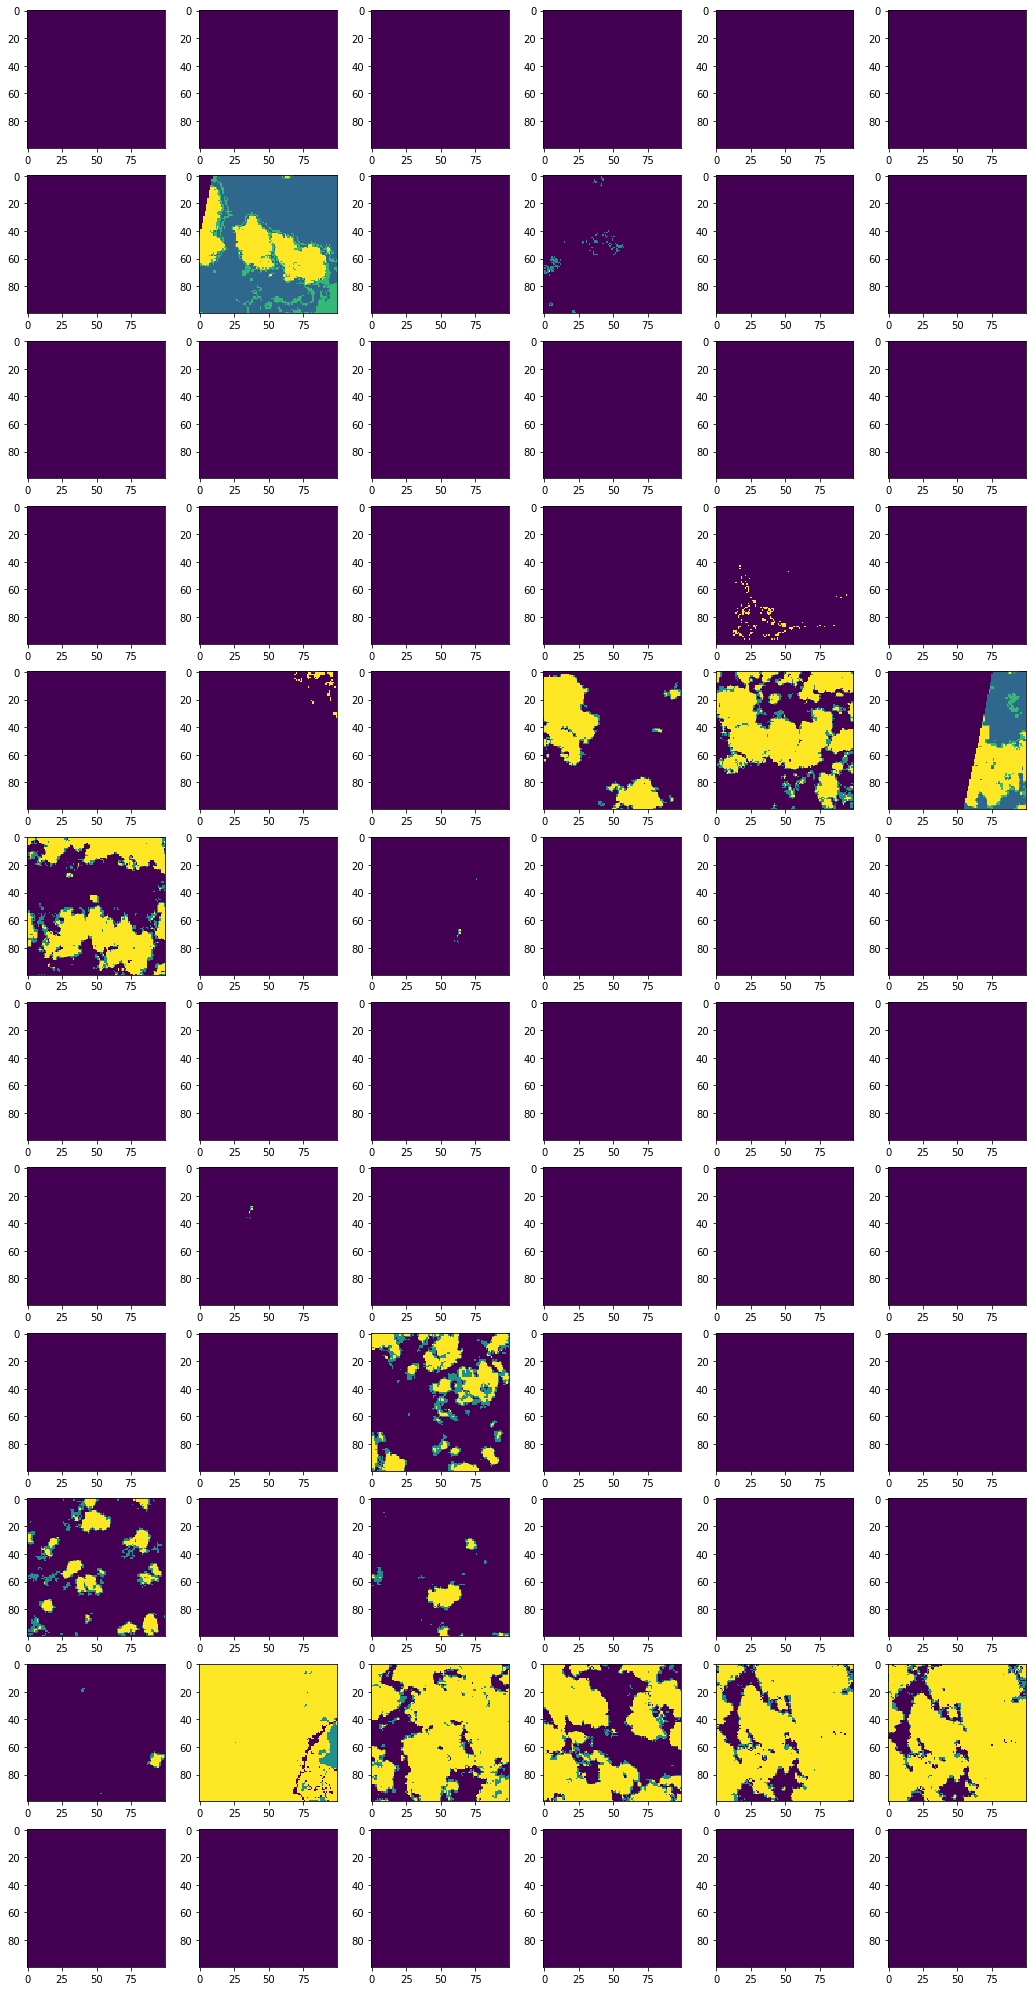

In [27]:
# Visualize mining site masks.

MAX_NUM_ROWS = 12

def divup(a, b):
    return int(np.ceil(a / b))

def plot_masks(imgs):
    num_imgs = imgs.shape[0]
    num_cols = 6
    num_rows = min(MAX_NUM_ROWS, divup(num_imgs, num_cols))

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 3,  num_rows * 3))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(imgs[i,:,:,0,0])
        
plot_masks(np.stack(imgs))